# Emissions Analysis for Houston and Berkeley
This notebook loads the CSV files, applies preprocessing, computes Pareto fronts, selects representative candidates, and visualizes the results.

In [25]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
houston = pd.read_csv("houston_results.csv").drop(30)
berkeley = pd.read_csv("berkeley_results.csv")
berkeley = berkeley.sort_values(by="operational_emissions_total_g", ascending=True).iloc[1:]

In [26]:
# Preprocessing
for df in [houston, berkeley]:
    df["embodied_emissions_initial_g"] = (
        df["solar"] / 4000 * 2520 +
        df["wind"] / 3000 * 1046 +
        df["battery"] / 7500 * 465
    ) * 1e6
    df["charge_cycles"] = df["total_battery_discharge_kwh"] / df["battery"]
    df["op_t_per_day"] = df["operational_emissions_total_g"] / 1e6 / 365

In [27]:
# Pareto front identification
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
            is_efficient[i] = True
    return is_efficient

houston_pareto = houston[is_pareto_efficient(houston[["embodied_emissions_initial_g", "operational_emissions_total_g"]].values)]
berkeley_pareto = berkeley[is_pareto_efficient(berkeley[["embodied_emissions_initial_g", "operational_emissions_total_g"]].values)]

In [28]:
# Select 5 diverse candidates
def select_representatives(df, n=5):
    norm = df[["embodied_emissions_initial_g", "operational_emissions_total_g"]]
    norm = (norm - norm.min()) / (norm.max() - norm.min())
    df = df.copy()
    df["norm_emb"] = norm.iloc[:, 0]
    df["norm_op"] = norm.iloc[:, 1]
    e1 = df.loc[((df["norm_emb"] - 0)**2 + (df["norm_op"] - 1)**2).idxmin()]
    e2 = df.loc[((df["norm_emb"] - 1)**2 + (df["norm_op"] - 0)**2).idxmin()]
    selected = [e1]
    if not e1.equals(e2): selected.append(e2)
    remaining = df.drop([p.name for p in selected])
    while len(selected) < n:
        dists = remaining.apply(lambda row: min(np.linalg.norm(row[["norm_emb", "norm_op"]] - s[["norm_emb", "norm_op"]]) for _, s in pd.DataFrame(selected).iterrows()), axis=1)
        selected.append(remaining.loc[dists.idxmax()])
        remaining = remaining.drop(dists.idxmax())
    return pd.DataFrame(selected)

def select_by_embodied_bands(df, value_column="embodied_emissions_initial_g", metric_column="op_t_per_day"):
    thresholds = [0, 5_000_000_000, 10_000_000_000, 15_000_000_000, np.inf]
    selected = []

    for t in thresholds:
        if t == 0:
            candidates = df[df[value_column] == 0]
        elif t == np.inf:
            candidates = df
        else:
            candidates = df[df[value_column] <= t]

        if not candidates.empty:
            best = candidates.loc[candidates[metric_column].idxmin()]
            selected.append(best)

    return pd.DataFrame(selected)

houston_repr = select_by_embodied_bands(houston_pareto).sort_values("embodied_emissions_initial_g")
berkeley_repr = select_by_embodied_bands(berkeley_pareto).sort_values("embodied_emissions_initial_g")

In [29]:
houston_repr

,location,wind,solar,battery,operational_emissions_total_g,embodied_emissions_initial_g,embodied_emissions_g,coverage_pct,coverage_nobatt_pct,total_battery_discharge_kwh,total_excess_renewable_kwh,total_grid_draw_kwh,charge_cycles,op_t_per_day
634,houston,0,0,0,5.672758e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.510326e+07,NaN,15.541802
833,houston,12000,0,7500,2.145470e+09,4.649000e+09,8.061314e+08,71.073050,62.501533,1.144641e+06,1.132268e+07,5.535335e+06,152.618827,5.878001
9,houston,9000,8000,22500,6.950363e+08,9.573000e+09,2.055175e+09,91.786740,74.787724,2.909139e+06,1.288411e+07,1.764142e+06,129.295086,1.904209
897,houston,12000,12000,52500,8.855955e+07,1.499900e+10,4.438749e+09,99.112557,78.907712,3.744052e+06,2.184188e+07,2.279887e+05,71.315271,0.242629
238,houston,30000,40000,60000,7.479818e+06,3.938000e+10,6.070386e+09,100.000000,86.938989,2.435713e+06,8.966695e+07,1.948994e+04,40.595224,0.020493


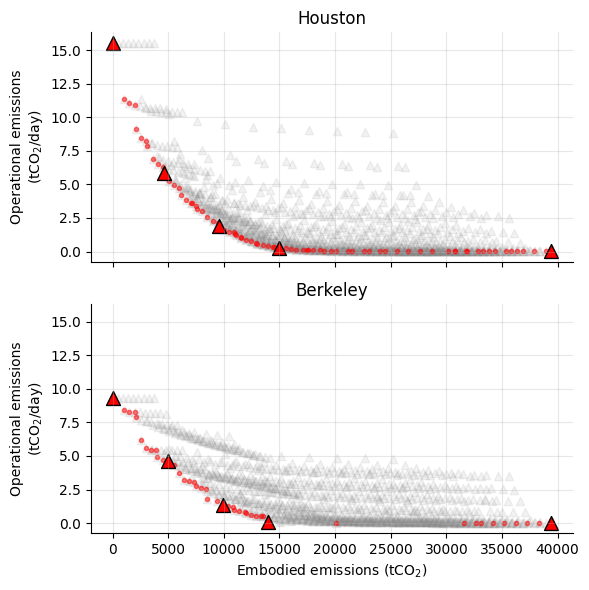

In [30]:
# Pareto front plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, sharey=True)
ax1.scatter(houston["embodied_emissions_initial_g"] / 1e6, houston["op_t_per_day"], color='gray', marker='^', alpha=0.1)
ax1.scatter(houston_pareto["embodied_emissions_initial_g"] / 1e6, houston_pareto["op_t_per_day"], marker='.', color='red', alpha=0.5)
ax1.scatter(houston_repr["embodied_emissions_initial_g"] / 1e6, houston_repr["op_t_per_day"], color='red', marker='^', s=100, edgecolors='black')
ax1.set_title("Houston")
ax1.set_ylabel("Operational emissions\n(tCO$_2$/day)")
ax1.grid(True, alpha=.3)

ax2.scatter(berkeley["embodied_emissions_initial_g"] / 1e6, berkeley["op_t_per_day"], color='gray', marker='^', alpha=0.1)
ax2.scatter(berkeley_pareto["embodied_emissions_initial_g"] / 1e6, berkeley_pareto["op_t_per_day"], marker='.', color='red', alpha=0.5)
ax2.scatter(berkeley_repr["embodied_emissions_initial_g"] / 1e6, berkeley_repr["op_t_per_day"], color='red', marker='^', s=100, edgecolors='black')
ax2.set_title("Berkeley")
ax2.set_xlabel("Embodied emissions (tCO$_2$)")
ax2.set_ylabel("Operational emissions\n(tCO$_2$/day)")
ax2.grid(True, alpha=.3)

sns.despine(fig)

plt.tight_layout()
plt.savefig("pareto.pdf", dpi=300, bbox_inches='tight')

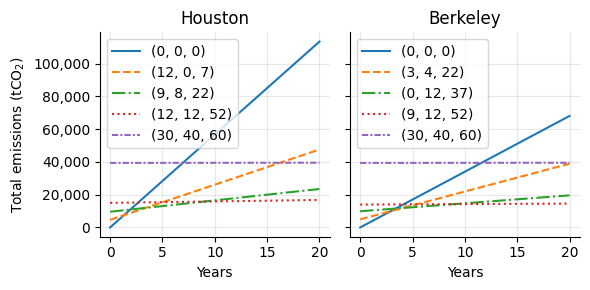

In [31]:
# Emissions over time plot
years = np.linspace(0, 20, 200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]

for i, (_, row) in enumerate(houston_repr.iterrows()):
    y = row["embodied_emissions_initial_g"] / 1e6 + years * row["op_t_per_day"] * 365
    label = f"({int(row['wind']//1000)}, {int(row['solar']//1000)}, {int(row['battery']//1000)})"
    ax1.plot(years, y, label=label, linestyle=line_styles[i % len(line_styles)])
ax1.set_title("Houston")
ax1.set_xlabel("Years")
ax1.set_ylabel("Total emissions (tCO$_2$)")
ax1.grid(True, alpha=.3)
ax1.legend(loc="upper left")
ax1.set_yticks([0,20000,40000,60000,80000,100000])
ax1.set_yticklabels([0,"20,000","40,000","60,000","80,000","100,000"])

for i, (_, row) in enumerate(berkeley_repr.iterrows()):
    y = row["embodied_emissions_initial_g"] / 1e6 + years * row["op_t_per_day"] * 365
    label = f"({int(row['wind']//1000)}, {int(row['solar']//1000)}, {int(row['battery']//1000)})"
    ax2.plot(years, y, label=label, linestyle=line_styles[i % len(line_styles)])
ax2.set_title("Berkeley")
ax2.set_xlabel("Years")
ax2.grid(True, alpha=.3)
ax2.legend(loc="upper left")

sns.despine(fig)

plt.tight_layout()
plt.savefig("longterm.pdf", dpi=300, bbox_inches='tight')

In [32]:
berkeley_repr

,location,wind,solar,battery,operational_emissions_total_g,embodied_emissions_initial_g,embodied_emissions_g,coverage_pct,coverage_nobatt_pct,total_battery_discharge_kwh,total_excess_renewable_kwh,total_grid_draw_kwh,charge_cycles,op_t_per_day
603,berkeley,0,0,0,3.404224e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.512063e+07,NaN,9.326642
61,berkeley,3000,4000,22500,1.697159e+09,4.961000e+09,1.808278e+09,60.110658,41.161514,1.848994e+06,7.937805e+05,7.724253e+06,82.177507,4.649750
486,berkeley,0,12000,37500,4.854387e+08,9.885000e+09,3.134475e+09,91.852109,39.601805,7.731399e+06,5.287292e+06,1.783544e+06,206.170651,1.329969
1048,berkeley,9000,12000,52500,3.058051e+07,1.395300e+10,4.913381e+09,99.567545,55.551570,7.251460e+06,4.092509e+07,1.102594e+05,138.123049,0.083782
273,berkeley,30000,40000,60000,6.477856e+06,3.938000e+10,5.869049e+09,99.954730,61.432425,6.335467e+06,6.689928e+07,2.754253e+04,105.591110,0.017748


In [33]:
ü = pd.DataFrame()
ü["Wind\n(kW)"] = (houston_repr["wind"] / 1000).astype('int')
ü["Solar\n(kW)"] = (houston_repr["solar"] / 1000).astype('int')
ü["Battery\n(MWh)"] = (houston_repr["battery"] / 1000).astype('int')

ü["Embodied\n(tCO$_2$)"] = (houston_repr["embodied_emissions_initial_g"] / 1000000).astype('int')
ü["Operational\n(tCO$_2$/day)"] = houston_repr["op_t_per_day"].round(2)

ü["Coverage\n(\%)"] = houston_repr["coverage_pct"].round(2)
ü["Charge\ncycles"] = houston_repr["charge_cycles"].round(0).apply(lambda a: int(a) if not np.isnan(a) else "-")
# ü["Grid draw"] = (houston_repr["total_grid_draw_kwh"] / 1000).astype('int')

ü

,Wind\n(kW),Solar\n(kW),Battery\n(MWh),Embodied\n(tCO$_2$),Operational\n(tCO$_2$/day),Coverage\n(\%),Charge\ncycles
634,0,0,0,0,15.54,0.00,-
833,12,0,7,4649,5.88,71.07,153
9,9,8,22,9573,1.90,91.79,129
897,12,12,52,14999,0.24,99.11,71
238,30,40,60,39380,0.02,100.00,41


In [34]:
ü = pd.DataFrame()
ü["Wind\n(kW)"] = (berkeley_repr["wind"] / 1000).astype('int')
ü["Solar\n(kW)"] = (berkeley_repr["solar"] / 1000).astype('int')
ü["Battery\n(MWh)"] = (berkeley_repr["battery"] / 1000).astype('int')

ü["Embodied\n(tCO$_2$)"] = (berkeley_repr["embodied_emissions_initial_g"] / 1000000).astype('int')
ü["Operational\n(tCO$_2$/day)"] = berkeley_repr["op_t_per_day"].round(2)

ü["Coverage\n(\%)"] = berkeley_repr["coverage_pct"].round(2)
ü["Charge\ncycles"] = berkeley_repr["charge_cycles"].round(0).apply(lambda a: int(a) if not np.isnan(a) else "-")
# ü["Grid draw"] = (houston_repr["total_grid_draw_kwh"] / 1000).astype('int')

ü

,Wind\n(kW),Solar\n(kW),Battery\n(MWh),Embodied\n(tCO$_2$),Operational\n(tCO$_2$/day),Coverage\n(\%),Charge\ncycles
603,0,0,0,0,9.33,0.00,-
61,3,4,22,4961,4.65,60.11,82
486,0,12,37,9885,1.33,91.85,206
1048,9,12,52,13953,0.08,99.57,138
273,30,40,60,39380,0.02,99.95,106


In [14]:
berkeley.loc[608]

location                                  berkeley
wind                                          9000
solar                                        36000
battery                                          0
operational_emissions_total_g                  0.0
embodied_emissions_initial_g         25818000000.0
embodied_emissions_g             1178406798.510424
coverage_pct                             57.134006
coverage_nobatt_pct                      57.134006
total_battery_discharge_kwh                    0.0
total_excess_renewable_kwh         56812885.318915
total_grid_draw_kwh                 6853014.942874
charge_cycles                                  NaN
op_t_per_day                                   0.0
Name: 608, dtype: object